In [74]:
import re
import random
import pandas as pd
import hashlib

In [75]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [76]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Powershell,436.197370,87.239474,5
Todd Ideas,745.981305,49.732087,15
PEP 8,1295.676957,161.959620,8
SharePoint,1500.638705,125.053225,12
Terraform,1711.111771,68.444471,25
Azure Functions + Visual Studio,1771.663121,126.547366,14
IW Migration,1939.855139,138.561081,14
Open Source/GitHub,2067.210118,129.200632,16
FSLogix,2086.294458,86.928936,24
Email Auth and Security,2201.109162,169.316089,13


# Histogram

83975.61


<Axes: >

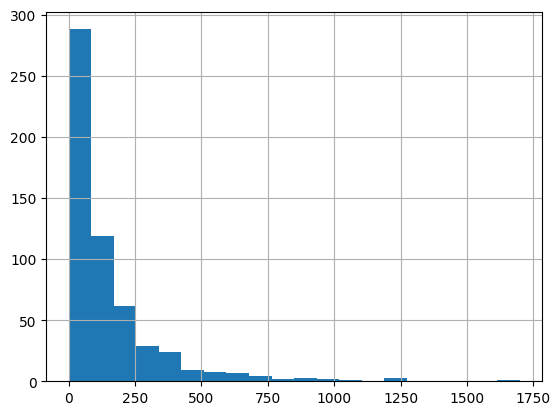

In [77]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [78]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [79]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [80]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [81]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [82]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [83]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [84]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [85]:
# n=10
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [86]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [87]:
n = 5
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 562


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
390,Debugging in VS Code,"Tracepoint\nSimilar to a breakpoint, but inste...",8e3dc41e4d0671d1414623cadf998af9,-1698.173120,191.064539,-1698.173120,4394.484390,0.865007,0,0
389,Debugging in VS Code,Debugger Attach\nA process where the debugger ...,af357c39bbc7c41fefdc2650a6587279,-558.169797,191.064539,-1698.173120,4394.484390,0.865007,1,0
388,Debugging in VS Code,Memory Inspection\nThe process of examining th...,bb5c882a35c5c01a517035a1f33346ad,-453.538469,191.064539,-1698.173120,4394.484390,0.865007,2,0
335,Debugging in VS Code,Reverse Debugging\nA debugging technique where...,53b8a03c463369e71dbcee2709b2f87a,-238.495810,191.064539,-1698.173120,4394.484390,0.865007,3,0
334,Debugging in VS Code,Variable Inspection\nThe process of viewing an...,25787b761b33ceb1bf8cb6aaf8dcbd8d,-202.523287,191.064539,-1698.173120,4394.484390,0.865007,4,0
336,Audit Report Tracker (Sharepoint List),Power Automate (Flow) Owner\nDefinition: A use...,8d5e063ee69a83e11e260335f0b685e8,-1231.730608,225.506616,-1231.730608,3608.105861,0.197580,0,0
242,Audit Report Tracker (Sharepoint List),Permissions Endpoint (for managing list permis...,eda0eb7c1a3a9b0ebba749a597e46d22,-417.967524,225.506616,-1231.730608,3608.105861,0.197580,1,0
241,Audit Report Tracker (Sharepoint List),Site Collection Administrator\nDefinition: A u...,c0359d229e67636a45dddedfe736bc8c,-384.931600,225.506616,-1231.730608,3608.105861,0.197580,2,0
240,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,-350.521359,225.506616,-1231.730608,3608.105861,0.197580,3,0
239,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-219.172333,225.506616,-1231.730608,3608.105861,0.197580,4,0


## Card Count

In [88]:
# n=10
# existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'frequency', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)




## Random

In [89]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [90]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
390,Debugging in VS Code,"Tracepoint\nSimilar to a breakpoint, but inste...",8e3dc41e4d0671d1414623cadf998af9,-1698.173120,191.064539,-1698.173120,4394.484390,0.865007,0,0
389,Debugging in VS Code,Debugger Attach\nA process where the debugger ...,af357c39bbc7c41fefdc2650a6587279,-558.169797,191.064539,-1698.173120,4394.484390,0.865007,1,0
388,Debugging in VS Code,Memory Inspection\nThe process of examining th...,bb5c882a35c5c01a517035a1f33346ad,-453.538469,191.064539,-1698.173120,4394.484390,0.865007,2,0
335,Debugging in VS Code,Reverse Debugging\nA debugging technique where...,53b8a03c463369e71dbcee2709b2f87a,-238.495810,191.064539,-1698.173120,4394.484390,0.865007,3,0
334,Debugging in VS Code,Variable Inspection\nThe process of viewing an...,25787b761b33ceb1bf8cb6aaf8dcbd8d,-202.523287,191.064539,-1698.173120,4394.484390,0.865007,4,0
336,Audit Report Tracker (Sharepoint List),Power Automate (Flow) Owner\nDefinition: A use...,8d5e063ee69a83e11e260335f0b685e8,-1231.730608,225.506616,-1231.730608,3608.105861,0.197580,0,0
242,Audit Report Tracker (Sharepoint List),Permissions Endpoint (for managing list permis...,eda0eb7c1a3a9b0ebba749a597e46d22,-417.967524,225.506616,-1231.730608,3608.105861,0.197580,1,0
241,Audit Report Tracker (Sharepoint List),Site Collection Administrator\nDefinition: A u...,c0359d229e67636a45dddedfe736bc8c,-384.931600,225.506616,-1231.730608,3608.105861,0.197580,2,0
240,Audit Report Tracker (Sharepoint List),View (SharePoint View)\nDefinition: A pre-defi...,c9375efcef5b15bae0f26f4f8d80a3f7,-350.521359,225.506616,-1231.730608,3608.105861,0.197580,3,0
239,Audit Report Tracker (Sharepoint List),List Administrator\nDefinition: A user with pe...,c04d54d96d16dfd514a229d890d7b6b4,-219.172333,225.506616,-1231.730608,3608.105861,0.197580,4,0


In [91]:
existing_cards['age'].mean()

-149.4228003856484